In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-jan-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-jan-2022/train.csv
/kaggle/input/tabular-playground-series-jan-2022/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc

warnings.filterwarnings("ignore")

# Tabular Playground Series - Dec 2021 

The tabular series on kaggle are meant to help novices in data science field to get acquainted with kaggle competitions.

For this challenge, we will be predicting a full year worth of sales for three items at two stores located in three different countries. This dataset is completely fictional, but contains many effects you see in real-world data, e.g., weekend and holiday effect, seasonality, etc. The dataset is small enough to allow you to try numerous different modeling approaches. 

# Exploratory Data Analysis

This is not finished yet

# Train dataset

Lets first explore the train dataset and subsequently the test dataset.

In [3]:
train_df = pd.read_csv("/kaggle/input/tabular-playground-series-jan-2022/train.csv", sep=',')

In [4]:
train_df.head()

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


In [5]:
train_df.tail()

,row_id,date,country,store,product,num_sold
26293,26293,2018-12-31,Sweden,KaggleMart,Kaggle Hat,823
26294,26294,2018-12-31,Sweden,KaggleMart,Kaggle Sticker,250
26295,26295,2018-12-31,Sweden,KaggleRama,Kaggle Mug,1004
26296,26296,2018-12-31,Sweden,KaggleRama,Kaggle Hat,1441
26297,26297,2018-12-31,Sweden,KaggleRama,Kaggle Sticker,388


In [6]:
print('Dataset shape: ', train_df.shape)

Dataset shape:  (26298, 6)


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26298 entries, 0 to 26297
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    26298 non-null  int64 
 1   date      26298 non-null  object
 2   country   26298 non-null  object
 3   store     26298 non-null  object
 4   product   26298 non-null  object
 5   num_sold  26298 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.2+ MB


In [8]:
train_df.dtypes.value_counts()

object    4
int64     2
dtype: int64

In [9]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
row_id,26298.0,13148.500000,7591.723026,0.0,6574.25,13148.5,19722.75,26297.0
num_sold,26298.0,387.533577,266.076193,70.0,190.00,315.0,510.00,2884.0


In [10]:
print("There are", train_df.isna().any().sum(), "missing values")

There are 0 missing values


# Date variable exploratory data analysis

In [11]:
train_df['date']

0        2015-01-01
1        2015-01-01
2        2015-01-01
3        2015-01-01
4        2015-01-01
            ...    
26293    2018-12-31
26294    2018-12-31
26295    2018-12-31
26296    2018-12-31
26297    2018-12-31
Name: date, Length: 26298, dtype: object

In [12]:
# How many days are valid datas e.g not weekends
dates = pd.to_datetime(train_df['date']).apply(lambda x: x.date()).unique()
valid_days = np.count_nonzero(np.is_busday(dates.astype('datetime64')))
print(valid_days, "valid days out of", len(dates))

1043 valid days out of 1461


In [13]:
# All years of data
years = set(map(lambda date: date.year, dates))
print("Years present in the data:", sorted(years))

Years present in the data: [2015, 2016, 2017, 2018]


In [14]:
months_each_year = {}
for year in years:
    months_each_year[year] = set([date.month for date in dates if date.year == year])

print("Year and Months of data for each year:")
months_each_year

Year and Months of data for each year:


{2016: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},
 2017: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},
 2018: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},
 2015: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}}

In [15]:
days_each_month_per_year = {}
for year in years:
    for month in months_each_year[year]:
        days_each_month_per_year[str(year) + '-' + str(month)] = len([date.day for date in dates if date.year == year and date.month == month])

print("Days of available data for each month each year:")
days_each_month_per_year

Days of available data for each month each year:


{'2016-1': 31,
 '2016-2': 29,
 '2016-3': 31,
 '2016-4': 30,
 '2016-5': 31,
 '2016-6': 30,
 '2016-7': 31,
 '2016-8': 31,
 '2016-9': 30,
 '2016-10': 31,
 '2016-11': 30,
 '2016-12': 31,
 '2017-1': 31,
 '2017-2': 28,
 '2017-3': 31,
 '2017-4': 30,
 '2017-5': 31,
 '2017-6': 30,
 '2017-7': 31,
 '2017-8': 31,
 '2017-9': 30,
 '2017-10': 31,
 '2017-11': 30,
 '2017-12': 31,
 '2018-1': 31,
 '2018-2': 28,
 '2018-3': 31,
 '2018-4': 30,
 '2018-5': 31,
 '2018-6': 30,
 '2018-7': 31,
 '2018-8': 31,
 '2018-9': 30,
 '2018-10': 31,
 '2018-11': 30,
 '2018-12': 31,
 '2015-1': 31,
 '2015-2': 28,
 '2015-3': 31,
 '2015-4': 30,
 '2015-5': 31,
 '2015-6': 30,
 '2015-7': 31,
 '2015-8': 31,
 '2015-9': 30,
 '2015-10': 31,
 '2015-11': 30,
 '2015-12': 31}

# Explanatory variables Distribution (Categorical Variables)

In [16]:
print("Unique values in every categorical variable\n")
print("country:", train_df['country'].unique())
print()
print("store:", train_df['store'].unique())
print()
print("product:", train_df['product'].unique()) 	 	

Unique values in every categorical variable

country: ['Finland' 'Norway' 'Sweden']

store: ['KaggleMart' 'KaggleRama']

product: ['Kaggle Mug' 'Kaggle Hat' 'Kaggle Sticker']


<h3> Total Sales made by Country </h3>

In [17]:
train_df.drop(['row_id'], axis=1).groupby(["country"]).sum()

,num_sold
country,
Finland,2680927
Norway,4404706
Sweden,3105725


<h3>Min and Max sales by country</h3>

In [18]:
train_df.drop(['row_id'], axis=1).groupby(["country"]).min()

,date,store,product,num_sold
country,,,,
Finland,2015-01-01,KaggleMart,Kaggle Hat,70
Norway,2015-01-01,KaggleMart,Kaggle Hat,114
Sweden,2015-01-01,KaggleMart,Kaggle Hat,86


In [19]:
train_df.drop(['row_id'], axis=1).groupby(["country"]).max()

,date,store,product,num_sold
country,,,,
Finland,2018-12-31,KaggleRama,Kaggle Sticker,1895
Norway,2018-12-31,KaggleRama,Kaggle Sticker,2884
Sweden,2018-12-31,KaggleRama,Kaggle Sticker,2169


<h3> Mean Sales made by Country </h3>

In [20]:
train_df.drop(['row_id'], axis=1).groupby(["country"]).mean()

,num_sold
country,
Finland,305.832421
Norway,502.476158
Sweden,354.292151


<h3>Total Sales made by country on each store</h3>

In [21]:
train_df.drop(['row_id'], axis=1).groupby(["country", "store"]).sum()

num_sold
country store               
Finland KaggleMart    978468
        KaggleRama   1702459
Norway  KaggleMart   1605045
        KaggleRama   2799661
Sweden  KaggleMart   1131855
        KaggleRama   1973870

<h3>Min and Max sales made by country on each store</h3>

In [22]:
train_df.drop(['row_id'], axis=1).groupby(["country", "store"]).min()

date     product  num_sold
country store                                       
Finland KaggleMart  2015-01-01  Kaggle Hat        70
        KaggleRama  2015-01-01  Kaggle Hat       128
Norway  KaggleMart  2015-01-01  Kaggle Hat       114
        KaggleRama  2015-01-01  Kaggle Hat       214
Sweden  KaggleMart  2015-01-01  Kaggle Hat        86
        KaggleRama  2015-01-01  Kaggle Hat       148

In [23]:
train_df.drop(['row_id'], axis=1).groupby(["country", "store"]).max()

date         product  num_sold
country store                                           
Finland KaggleMart  2018-12-31  Kaggle Sticker      1113
        KaggleRama  2018-12-31  Kaggle Sticker      1895
Norway  KaggleMart  2018-12-31  Kaggle Sticker      1809
        KaggleRama  2018-12-31  Kaggle Sticker      2884
Sweden  KaggleMart  2018-12-31  Kaggle Sticker      1207
        KaggleRama  2018-12-31  Kaggle Sticker      2169

<h3>Mean Sales made by country on each store</h3>

In [24]:
train_df.drop(['row_id'], axis=1).groupby(["country", "store"]).mean()

num_sold
country store                 
Finland KaggleMart  223.241615
        KaggleRama  388.423226
Norway  KaggleMart  366.197810
        KaggleRama  638.754506
Sweden  KaggleMart  258.237509
        KaggleRama  450.346794

<h3>Total Sales made by country on each store for each product</h3>

In [25]:
train_df.drop(['row_id'], axis=1).groupby(["country", "store", "product"]).sum()

num_sold
country store      product                 
Finland KaggleMart Kaggle Hat        529583
                   Kaggle Mug        298337
                   Kaggle Sticker    150548
        KaggleRama Kaggle Hat        918862
                   Kaggle Mug        520278
                   Kaggle Sticker    263319
Norway  KaggleMart Kaggle Hat        868777
                   Kaggle Mug        488515
                   Kaggle Sticker    247753
        KaggleRama Kaggle Hat       1514119
                   Kaggle Mug        853659
                   Kaggle Sticker    431883
Sweden  KaggleMart Kaggle Hat        612472
                   Kaggle Mug        344628
                   Kaggle Sticker    174755
        KaggleRama Kaggle Hat       1068652
                   Kaggle Mug        600870
                   Kaggle Sticker    304348

<h3>Min and Max Sales made by country on each store for each product</h3>

In [26]:
train_df.drop(['row_id'], axis=1).groupby(["country", "store", "product"]).min()

date  num_sold
country store      product                             
Finland KaggleMart Kaggle Hat      2015-01-01       210
                   Kaggle Mug      2015-01-01       126
                   Kaggle Sticker  2015-01-01        70
        KaggleRama Kaggle Hat      2015-01-01       354
                   Kaggle Mug      2015-01-01       220
                   Kaggle Sticker  2015-01-01       128
Norway  KaggleMart Kaggle Hat      2015-01-01       335
                   Kaggle Mug      2015-01-01       201
                   Kaggle Sticker  2015-01-01       114
        KaggleRama Kaggle Hat      2015-01-01       596
                   Kaggle Mug      2015-01-01       366
                   Kaggle Sticker  2015-01-01       214
Sweden  KaggleMart Kaggle Hat      2015-01-01       248
                   Kaggle Mug      2015-01-01       149
                   Kaggle Sticker  2015-01-01        86
        KaggleRama Kaggle Hat      2015-01-01       428
                   Kaggle Mug      2015-01-01       253
                   Kaggle Sticker  2015-01-01       148

In [27]:
train_df.drop(['row_id'], axis=1).groupby(["country", "store", "product"]).max()

date  num_sold
country store      product                             
Finland KaggleMart Kaggle Hat      2018-12-31      1113
                   Kaggle Mug      2018-12-31       774
                   Kaggle Sticker  2018-12-31       326
        KaggleRama Kaggle Hat      2018-12-31      1895
                   Kaggle Mug      2018-12-31      1398
                   Kaggle Sticker  2018-12-31       559
Norway  KaggleMart Kaggle Hat      2018-12-31      1809
                   Kaggle Mug      2018-12-31      1113
                   Kaggle Sticker  2018-12-31       518
        KaggleRama Kaggle Hat      2018-12-31      2884
                   Kaggle Mug      2018-12-31      1935
                   Kaggle Sticker  2018-12-31       874
Sweden  KaggleMart Kaggle Hat      2018-12-31      1207
                   Kaggle Mug      2018-12-31       730
                   Kaggle Sticker  2018-12-31       356
        KaggleRama Kaggle Hat      2018-12-31      2169
                   Kaggle Mug      2018-12-31      1438
                   Kaggle Sticker  2018-12-31       637

<h3>Mean Sales made by country on each store for each product</h3>

In [28]:
train_df.drop(['row_id'], axis=1).groupby(["country", "store", "product"]).mean()

num_sold
country store      product                    
Finland KaggleMart Kaggle Hat       362.479808
                   Kaggle Mug       204.200548
                   Kaggle Sticker   103.044490
        KaggleRama Kaggle Hat       628.926762
                   Kaggle Mug       356.110883
                   Kaggle Sticker   180.232033
Norway  KaggleMart Kaggle Hat       594.645448
                   Kaggle Mug       334.370294
                   Kaggle Sticker   169.577687
        KaggleRama Kaggle Hat      1036.357974
                   Kaggle Mug       584.297741
                   Kaggle Sticker   295.607803
Sweden  KaggleMart Kaggle Hat       419.214237
                   Kaggle Mug       235.885010
                   Kaggle Sticker   119.613279
        KaggleRama Kaggle Hat       731.452430
                   Kaggle Mug       411.273101
                   Kaggle Sticker   208.314853

<h3>The most sold product</h3>

In [29]:
train_df.drop(['row_id'], axis=1).groupby(["product"]).max()

,date,country,store,num_sold
product,,,,
Kaggle Hat,2018-12-31,Sweden,KaggleRama,2884
Kaggle Mug,2018-12-31,Sweden,KaggleRama,1935
Kaggle Sticker,2018-12-31,Sweden,KaggleRama,874


<h3>The lesser sold product</h3>

In [30]:
train_df.drop(['row_id'], axis=1).groupby(["product"]).min()

,date,country,store,num_sold
product,,,,
Kaggle Hat,2015-01-01,Finland,KaggleMart,210
Kaggle Mug,2015-01-01,Finland,KaggleMart,126
Kaggle Sticker,2015-01-01,Finland,KaggleMart,70


<h3>Count plot of every categorical variable</h3>

The number of items sold is almost the same for every country, every product and every store. Every categorical variable is perfectly balanced.

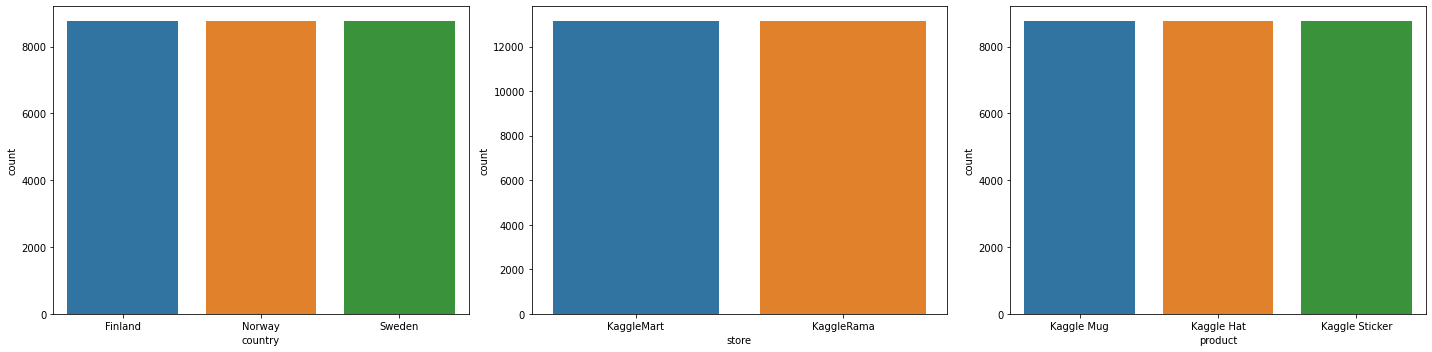

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax = ax.flatten()
columns = train_df.select_dtypes(include='object').drop('date', axis=1).columns

for i, column in enumerate(columns):
    sns.countplot(x=train_df[column], ax=ax[i])

plt.tight_layout()
fig.show()

<h3>Box plot, violin plot and swarmplot of every categorical variable against the target variable (num_sold)</h3>

From the boxplots below we can observe the following:

1. Norway sold a bigger number of items than Finland and Sweden
2. The store Kaggle Rama Sold much more items than the Kaggle Mart;
3. Kaggle Hat has is the product most sold, followed by Kaggle Mug, and Kaggle Sticker the less sold product.

<h4>country  num_sold boxplot and violinplot</h4>

<AxesSubplot:xlabel='country', ylabel='num_sold'>

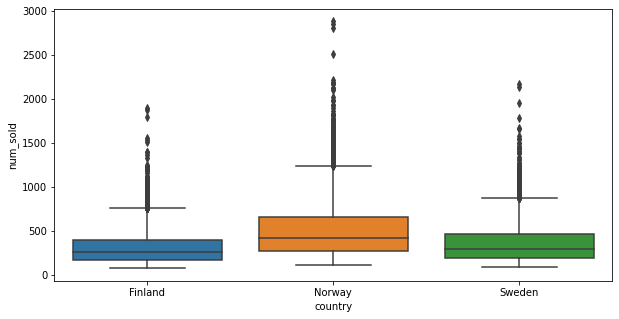

In [32]:
categorical_vars = ['country', 'store', 'product']

plt.figure(figsize=(10, 5))
sns.boxplot(data = train_df, x='country', y='num_sold')

<AxesSubplot:xlabel='country', ylabel='num_sold'>

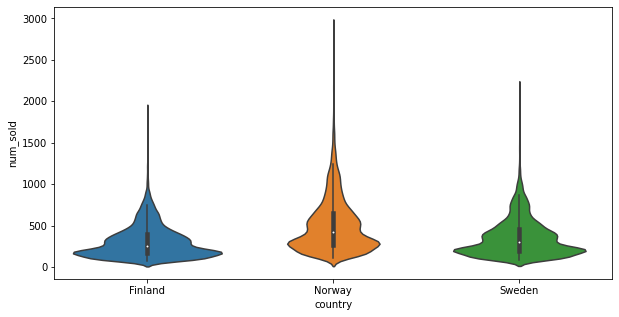

In [33]:
plt.figure(figsize=(10, 5))
sns.violinplot(data = train_df, x='country', y='num_sold')

<h4>store  num_sold boxplot and violinplot</h4>

<AxesSubplot:xlabel='store', ylabel='num_sold'>

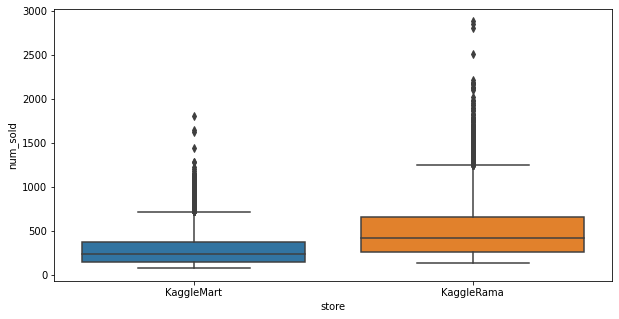

In [34]:
plt.figure(figsize=(10, 5))
sns.boxplot(data = train_df, x='store', y='num_sold')

<AxesSubplot:xlabel='store', ylabel='num_sold'>

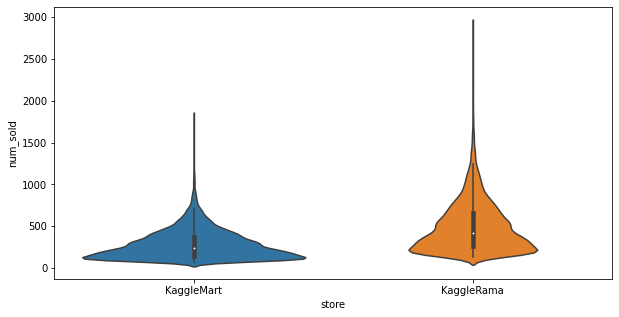

In [35]:
plt.figure(figsize=(10, 5))
sns.violinplot(data = train_df, x='store', y='num_sold')

<h4>product  num_sold boxplot and violinplot</h4>

<AxesSubplot:xlabel='product', ylabel='num_sold'>

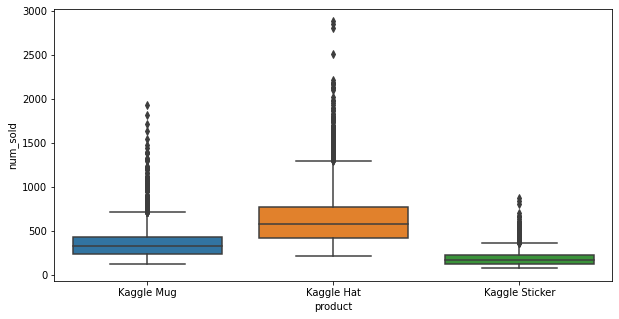

In [36]:
plt.figure(figsize=(10, 5))
sns.boxplot(data = train_df, x='product', y='num_sold')

<AxesSubplot:xlabel='product', ylabel='num_sold'>

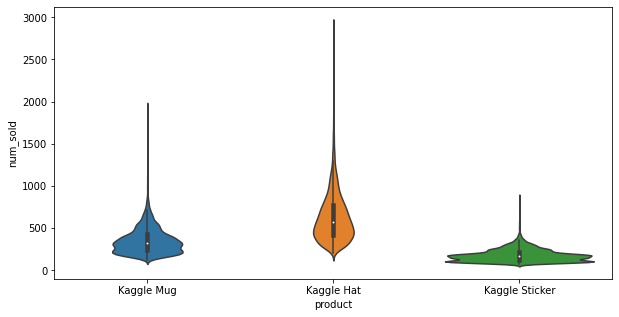

In [37]:
plt.figure(figsize=(10, 5))
sns.violinplot(data = train_df, x='product', y='num_sold')

<AxesSubplot:xlabel='country', ylabel='count'>

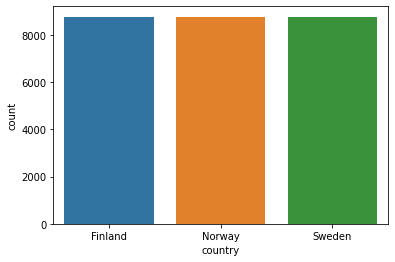

In [38]:
sns.countplot(data = train_df, x = 'country')

train_dfget Variable Distribution

<AxesSubplot:xlabel='num_sold', ylabel='Density'>

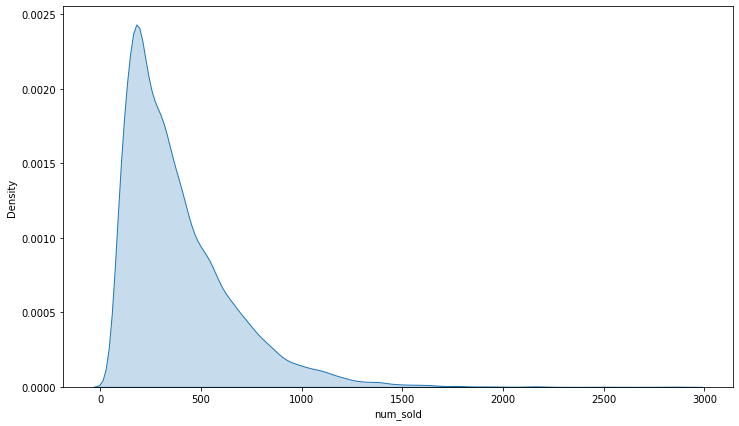

In [39]:
# Target Distribution
plt.figure(figsize=(12, 7))
sns.kdeplot(data=train_df, x='num_sold', palette = ["#2a9d8f"], shade=True)

<h3>Full Series</h3>

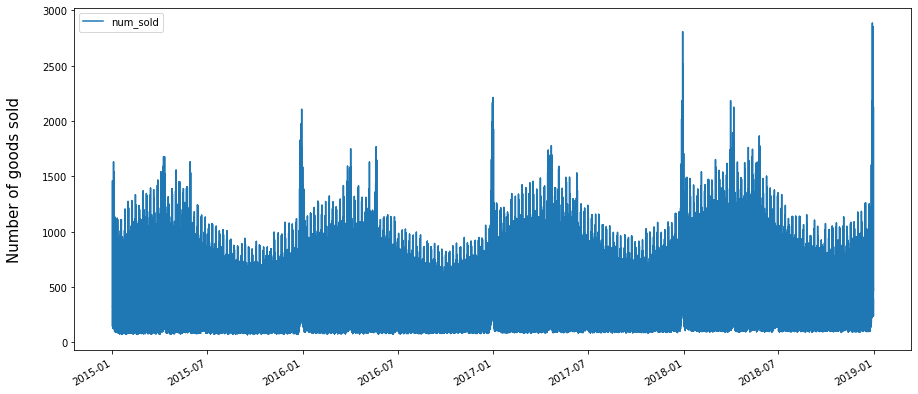

In [40]:
df = pd.DataFrame({'num_sold' : train_df['num_sold'].values}, index=pd.to_datetime(train_df['date'].values))
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.grid(which='both')
ax.legend(['Target variable (num_sold)'], loc="upper left")
ax.set_ylabel('Number of goods sold', labelpad=20, fontsize=15)
df.plot(ax=ax)
plt.show()

# Yearly series


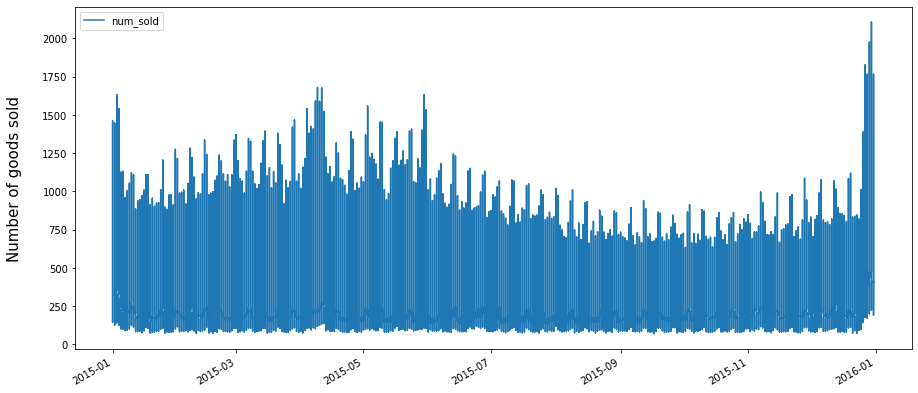

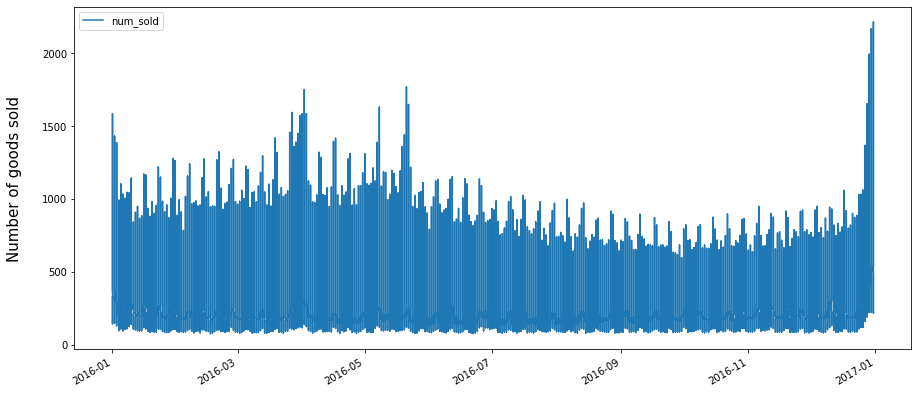

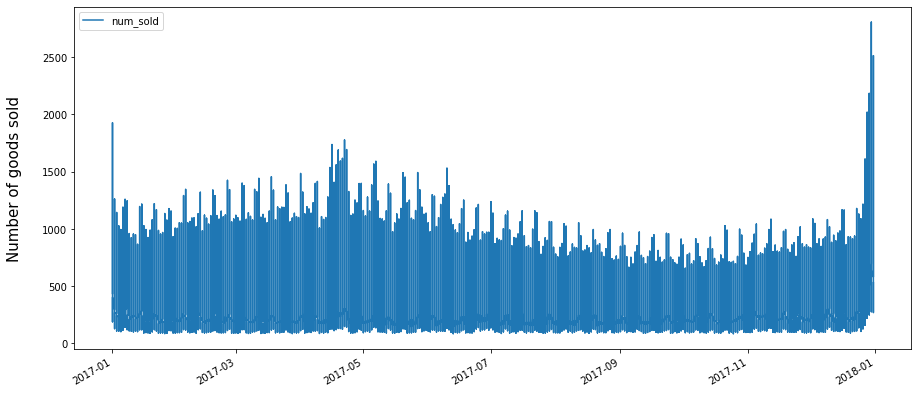

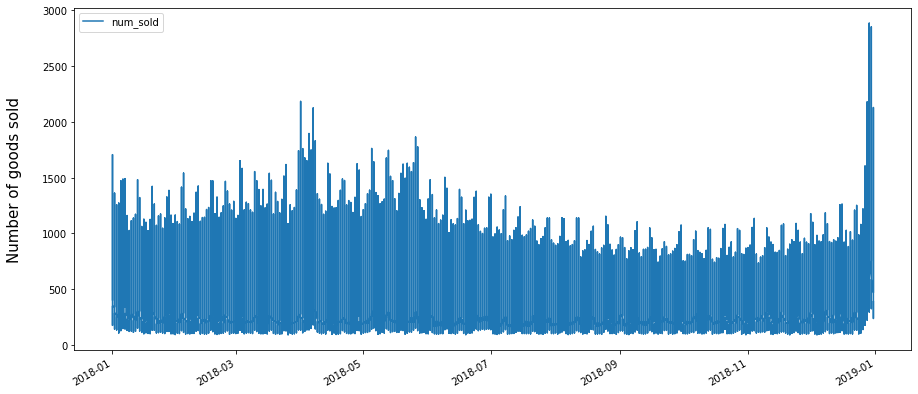

In [41]:
df = pd.DataFrame({'num_sold' : train_df['num_sold'].values}, index=pd.to_datetime(train_df['date'].values))
years = df.index.year.unique()

for year in years:
    df_year = df[df.index.year == year]
    fig, ax = plt.subplots(1, 1, figsize=(15, 7))
    ax.grid(which='both')
    ax.legend(['Target variable (num_sold)'], loc="upper left")
    ax.set_ylabel('Number of goods sold', labelpad=20, fontsize=15)
    df_year.plot(ax=ax)
    plt.show()

# Yearly num_sold by country


--- Finland ---



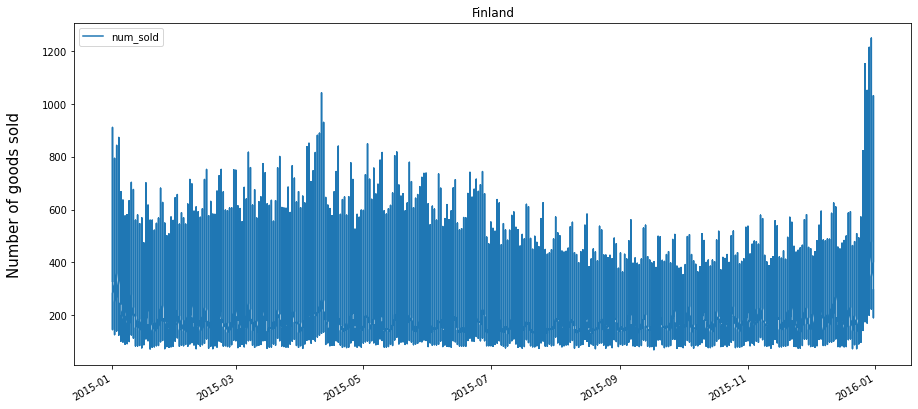

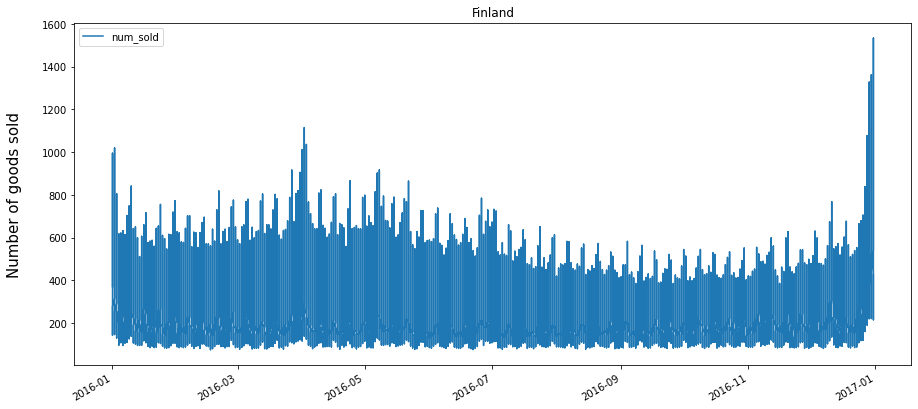

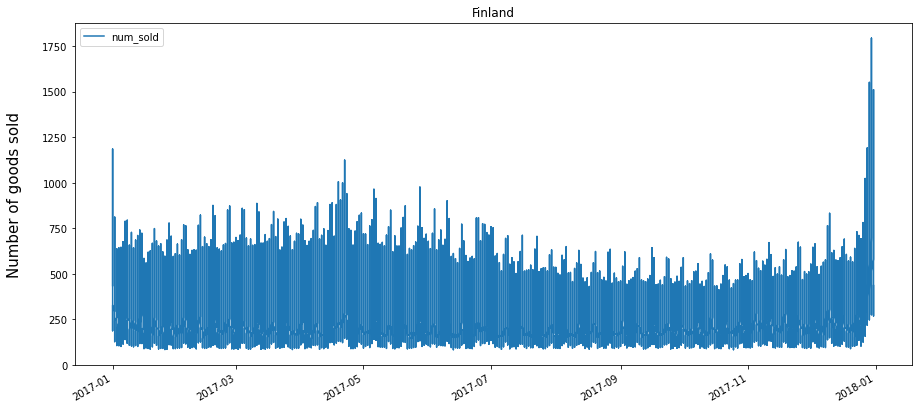

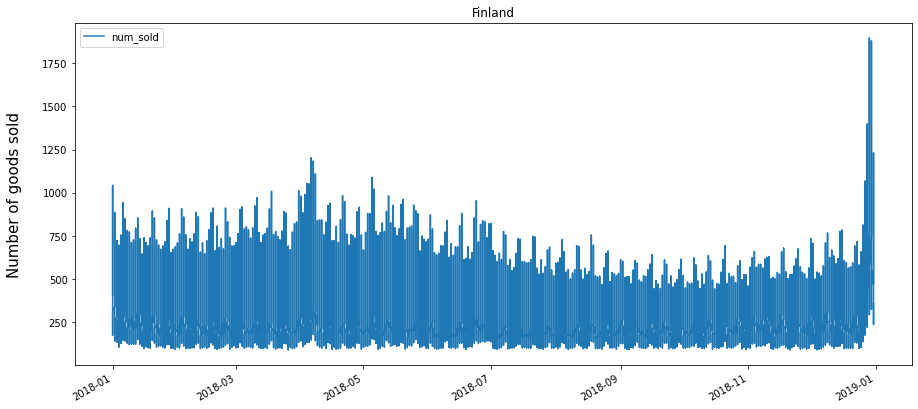


--- Norway ---



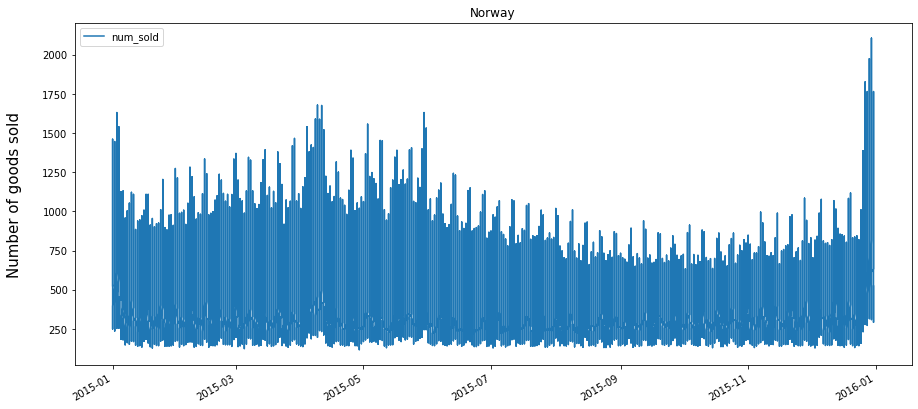

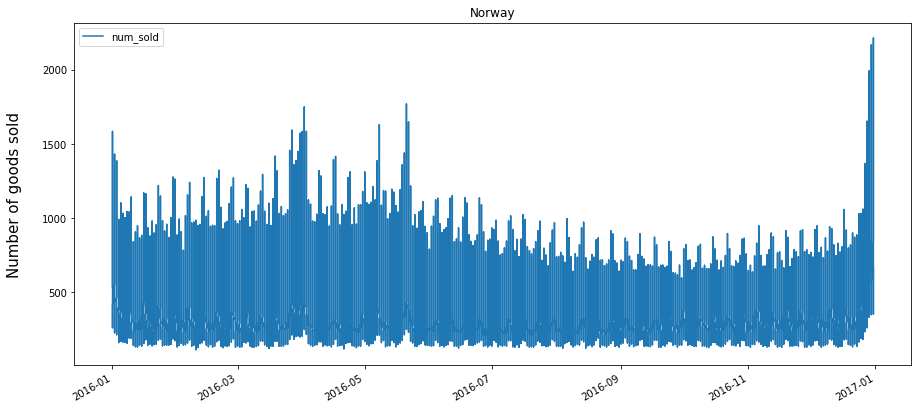

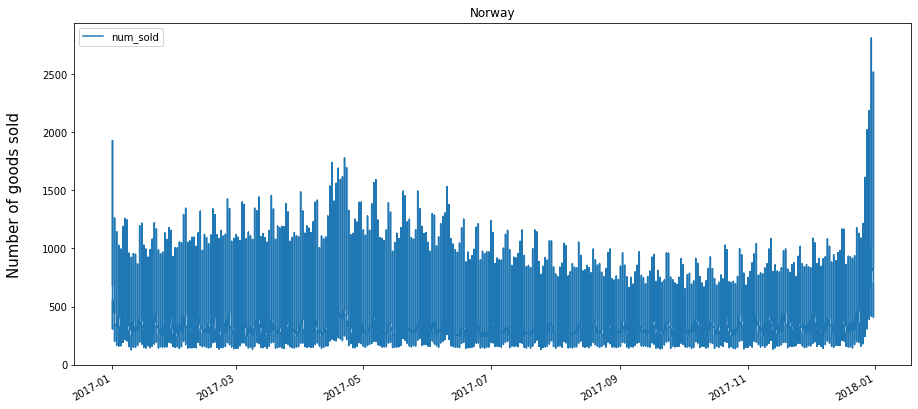

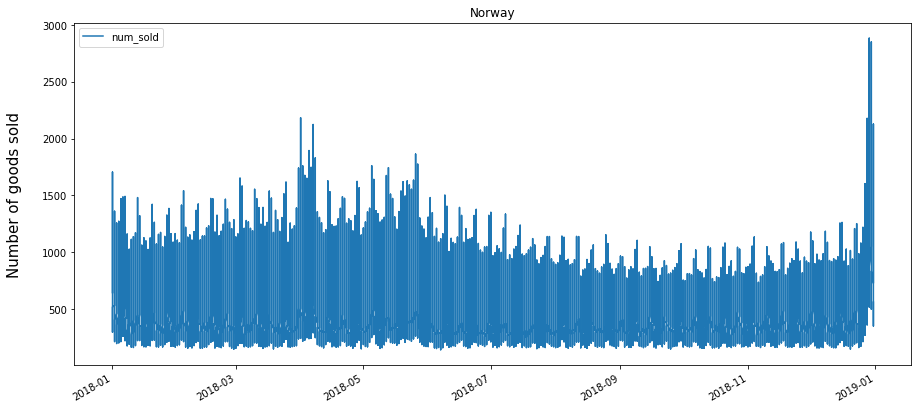


--- Sweden ---



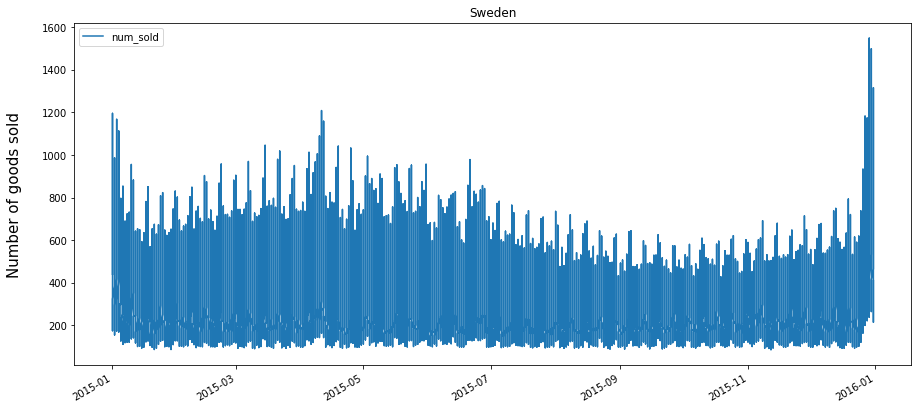

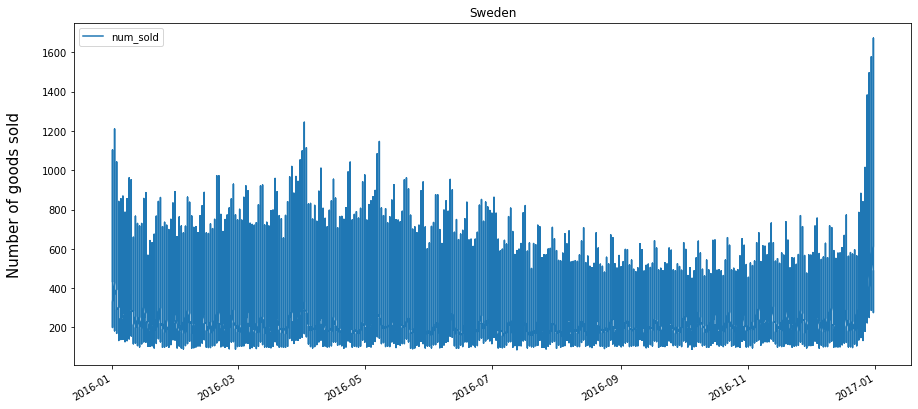

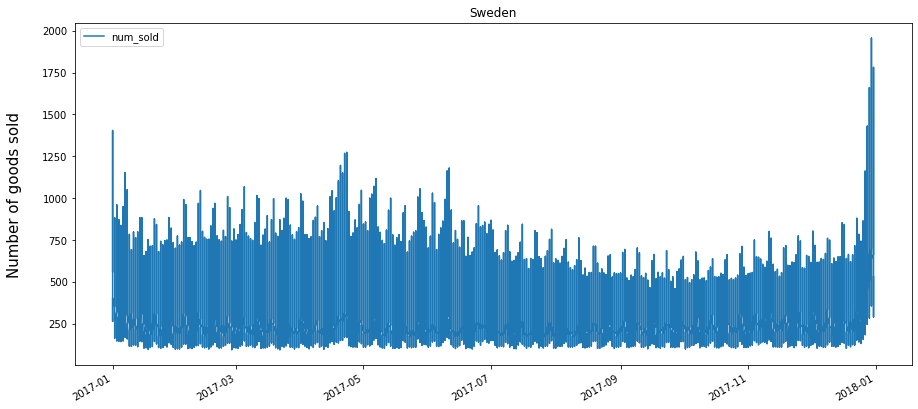

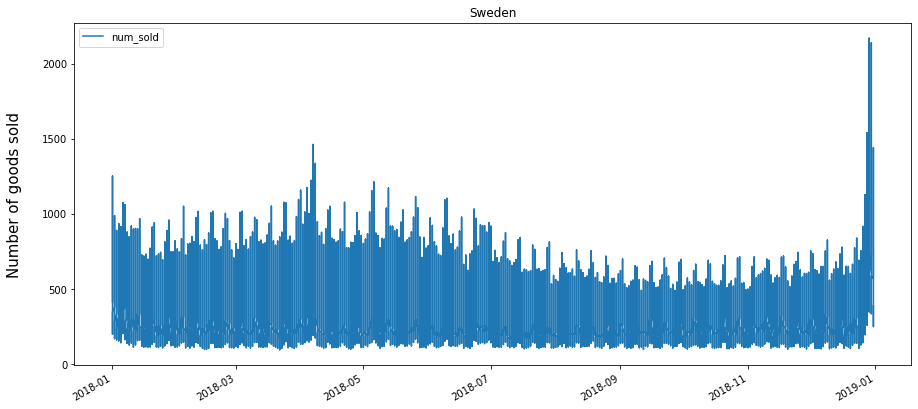

In [42]:
df = pd.DataFrame({'num_sold' : train_df['num_sold'].values,
                   'country'  : train_df['country'].values},
                  index=pd.to_datetime(train_df['date'].values))

years = df.index.year.unique()
countries = train_df.country.unique()

for country in countries:
    print(f"\n--- {country} ---\n")
    for year in years:
        df_year = df[(df.index.year == year) & (df.country == country)]
        fig, ax = plt.subplots(1, 1, figsize=(15, 7))
        fig.subplots_adjust(hspace=0.30)
        ax.grid(which='both')
        ax.legend(['Target variable (num_sold)'], loc="upper left")
        ax.set_ylabel('Number of goods sold', labelpad=20, fontsize=15)
        df_year.plot(ax=ax, title=country)
        plt.show()

# Yearly total num_sold by month for each country


--- Finland ---



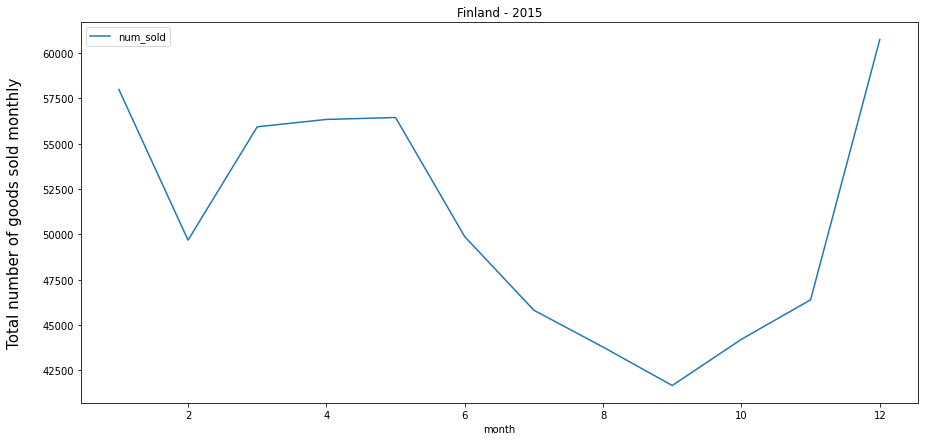

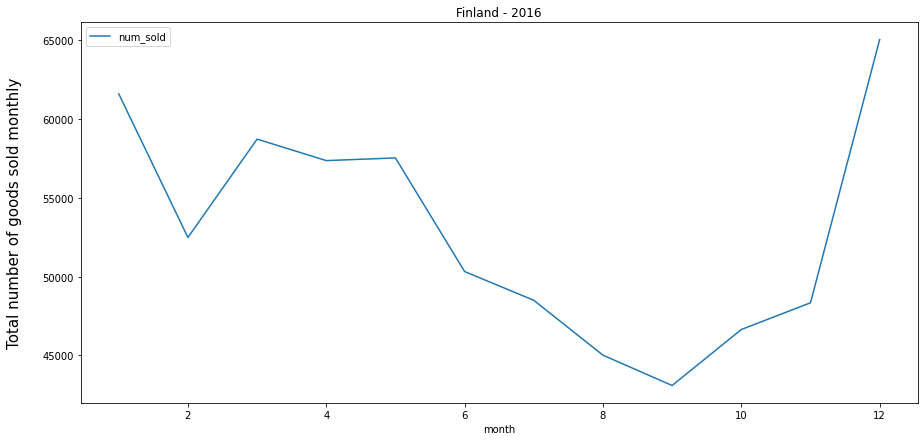

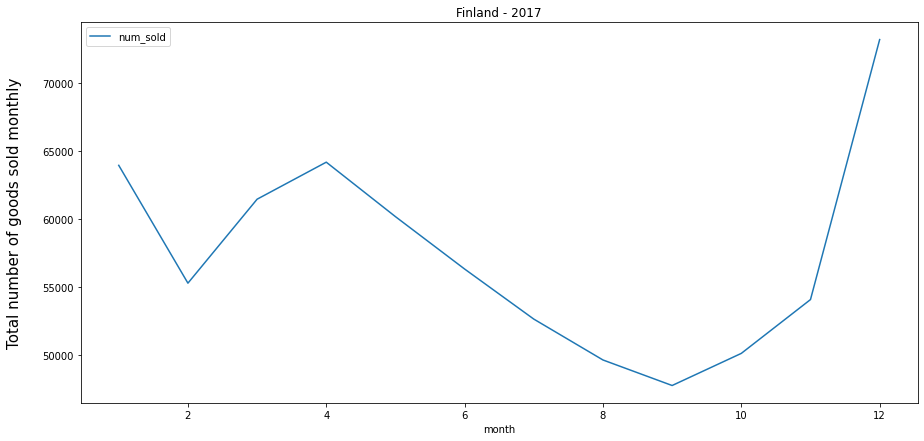

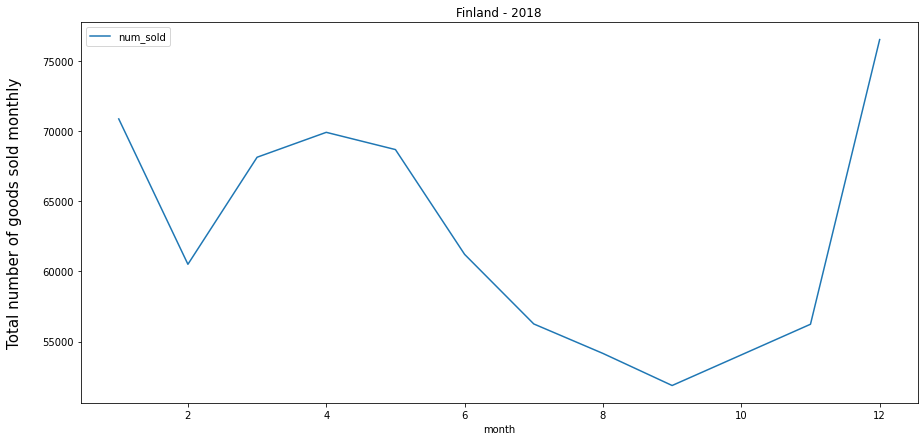


--- Norway ---



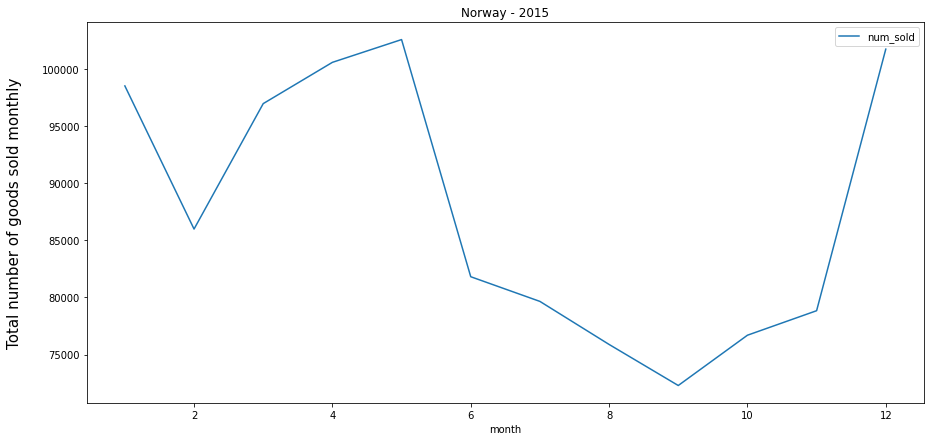

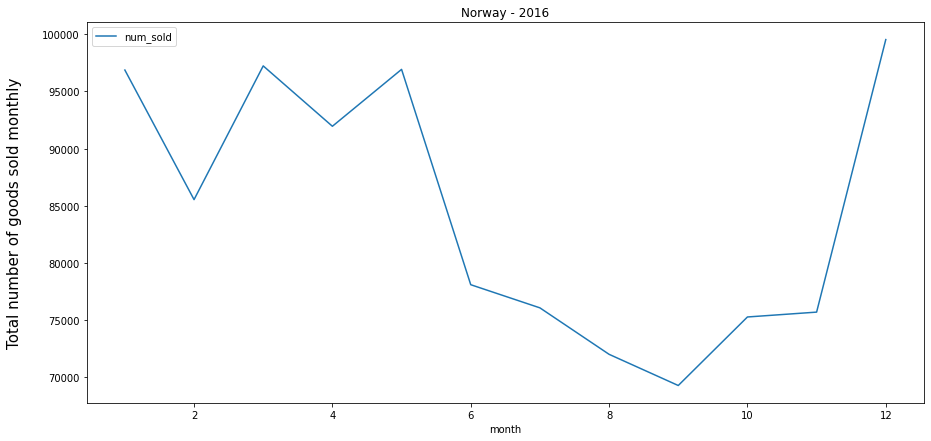

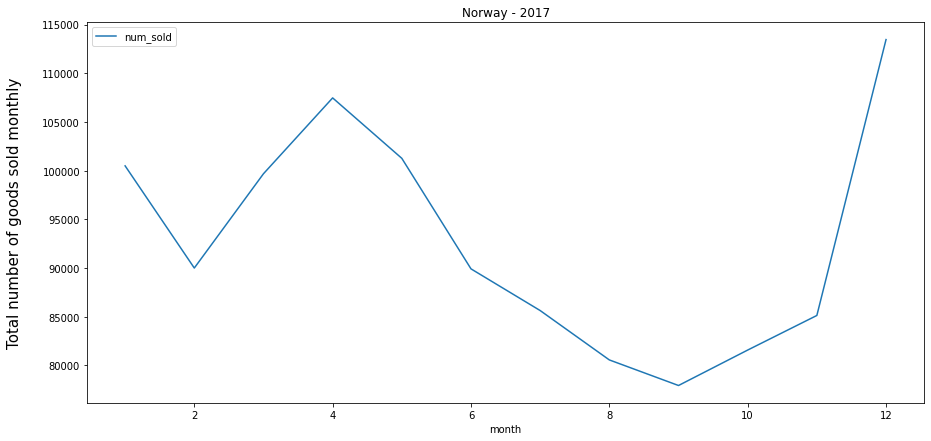

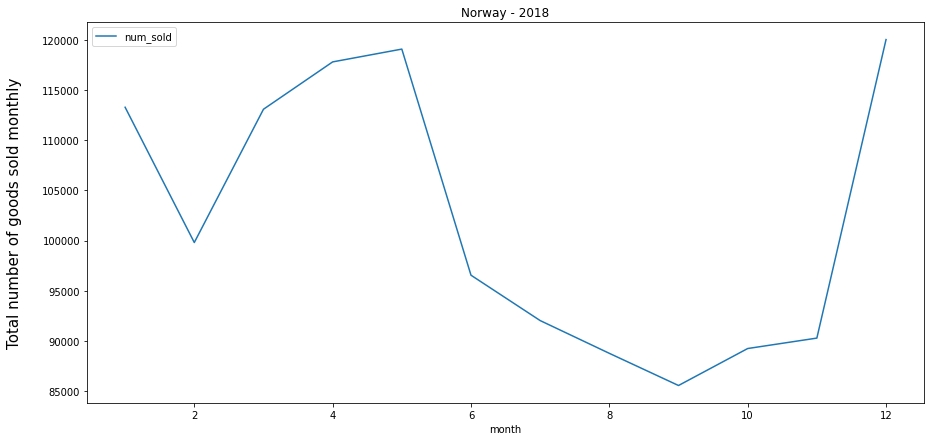


--- Sweden ---



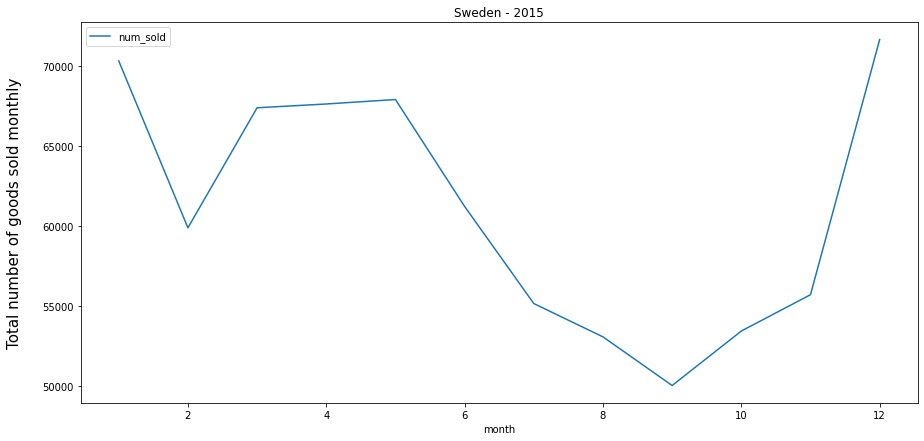

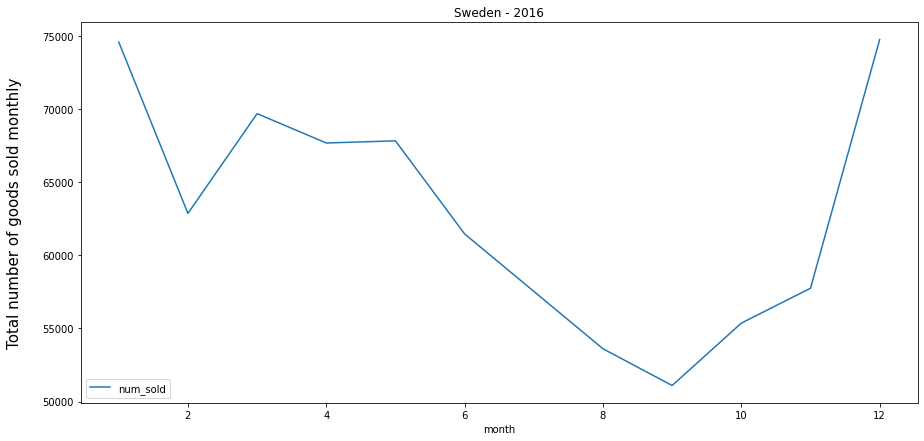

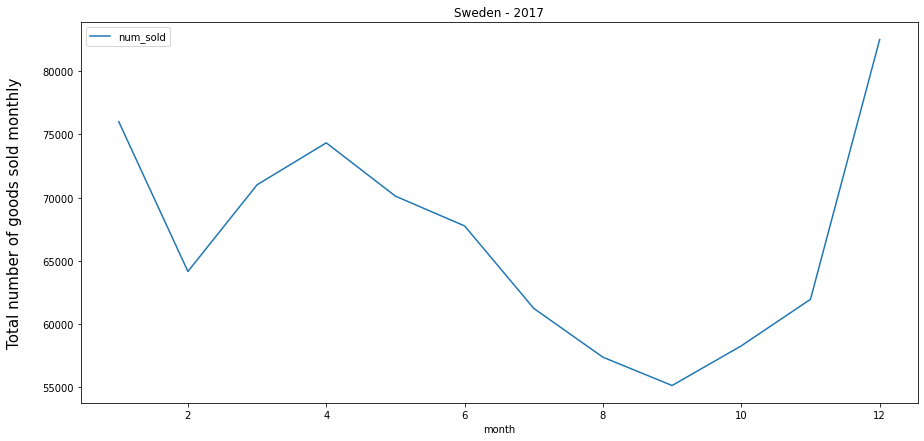

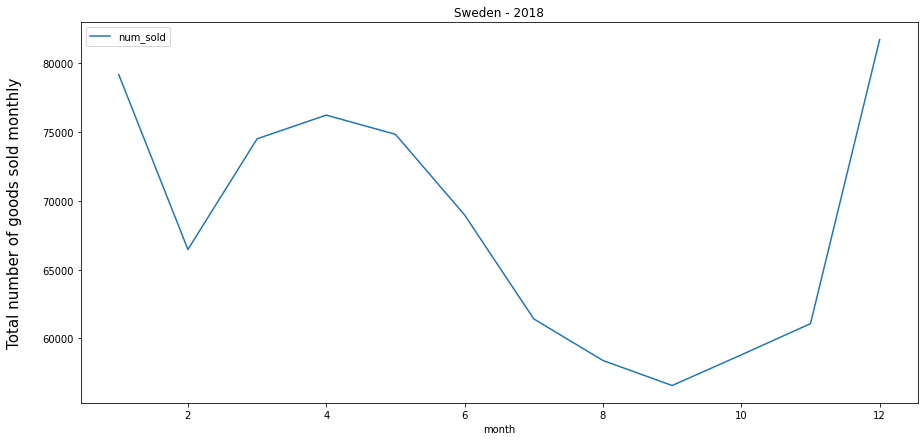

In [43]:
df = pd.DataFrame({'num_sold' : train_df['num_sold'].values,
                   'country'  : train_df['country'].values},
                  
                  index=pd.to_datetime(train_df['date'].values))

df['month'] = df.index.month
years = df.index.year.unique()
countries = train_df.country.unique()

for country in countries:
    print(f"\n--- {country} ---\n")
    for year in years:
        df_year = df[(df.index.year == year) & (df.country == country)]
        df_year = df_year.groupby("month").sum()        
        fig, ax = plt.subplots(1, 1, figsize=(15, 7))
        
        # fig.subplots_adjust(hspace=0.30)
        ax.grid(which='both')
        ax.legend(['Target variable (num_sold)'], loc="upper left")
        ax.set_ylabel('Total number of goods sold monthly', labelpad=20, fontsize=15)
        df_year.plot(ax=ax, title=country + " - " + str(year))
        plt.show()

# Test dataset

For the test dataset we will only check for missing values and if all classes are present in the data. The information gathered below shows that
the test data is similar to the train data.

In [44]:
test_df = pd.read_csv("/kaggle/input/tabular-playground-series-jan-2022/test.csv", sep=',')

In [45]:
test_df.head()

,row_id,date,country,store,product
0,26298,2019-01-01,Finland,KaggleMart,Kaggle Mug
1,26299,2019-01-01,Finland,KaggleMart,Kaggle Hat
2,26300,2019-01-01,Finland,KaggleMart,Kaggle Sticker
3,26301,2019-01-01,Finland,KaggleRama,Kaggle Mug
4,26302,2019-01-01,Finland,KaggleRama,Kaggle Hat


In [46]:
test_df.tail()

,row_id,date,country,store,product
6565,32863,2019-12-31,Sweden,KaggleMart,Kaggle Hat
6566,32864,2019-12-31,Sweden,KaggleMart,Kaggle Sticker
6567,32865,2019-12-31,Sweden,KaggleRama,Kaggle Mug
6568,32866,2019-12-31,Sweden,KaggleRama,Kaggle Hat
6569,32867,2019-12-31,Sweden,KaggleRama,Kaggle Sticker


In [47]:
print('Dataset shape: ', test_df.shape)

Dataset shape:  (6570, 5)


In [48]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6570 entries, 0 to 6569
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   row_id   6570 non-null   int64 
 1   date     6570 non-null   object
 2   country  6570 non-null   object
 3   store    6570 non-null   object
 4   product  6570 non-null   object
dtypes: int64(1), object(4)
memory usage: 256.8+ KB


In [49]:
test_df.dtypes.value_counts()

object    4
int64     1
dtype: int64

In [50]:
print("There are", test_df.isna().any().sum(), "missing values")

There are 0 missing values


In [51]:
print("Unique values in every categorical variable\n")
print("country:", test_df['country'].unique())
print()
print("store:", test_df['store'].unique())
print()
print("product:", test_df['product'].unique()) 	 	

Unique values in every categorical variable

country: ['Finland' 'Norway' 'Sweden']

store: ['KaggleMart' 'KaggleRama']

product: ['Kaggle Mug' 'Kaggle Hat' 'Kaggle Sticker']


In [52]:
test_df['date']

0       2019-01-01
1       2019-01-01
2       2019-01-01
3       2019-01-01
4       2019-01-01
           ...    
6565    2019-12-31
6566    2019-12-31
6567    2019-12-31
6568    2019-12-31
6569    2019-12-31
Name: date, Length: 6570, dtype: object

In [53]:
# How many days are valid datas e.g not weekends
dates = pd.to_datetime(test_df['date']).apply(lambda x: x.date()).unique()
valid_days = np.count_nonzero(np.is_busday(dates.astype('datetime64')))
print(valid_days, "valid days out of", len(dates))

261 valid days out of 365


In [54]:
# All years of data
years = set(map(lambda date: date.year, dates))
print("Years present in the data:", sorted(years))

Years present in the data: [2019]


In [55]:
months_each_year = {}
for year in years:
    months_each_year[year] = set([date.month for date in dates if date.year == year])

print("Year and Months of data for each year:")
months_each_year

Year and Months of data for each year:


{2019: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}}

In [56]:
days_each_month_per_year = {}
for year in years:
    for month in months_each_year[year]:
        days_each_month_per_year[str(year) + '-' + str(month)] = len([date.day for date in dates if date.year == year and date.month == month])

print("Days of available data for each month each year:")
days_each_month_per_year

Days of available data for each month each year:


{'2019-1': 31,
 '2019-2': 28,
 '2019-3': 31,
 '2019-4': 30,
 '2019-5': 31,
 '2019-6': 30,
 '2019-7': 31,
 '2019-8': 31,
 '2019-9': 30,
 '2019-10': 31,
 '2019-11': 30,
 '2019-12': 31}

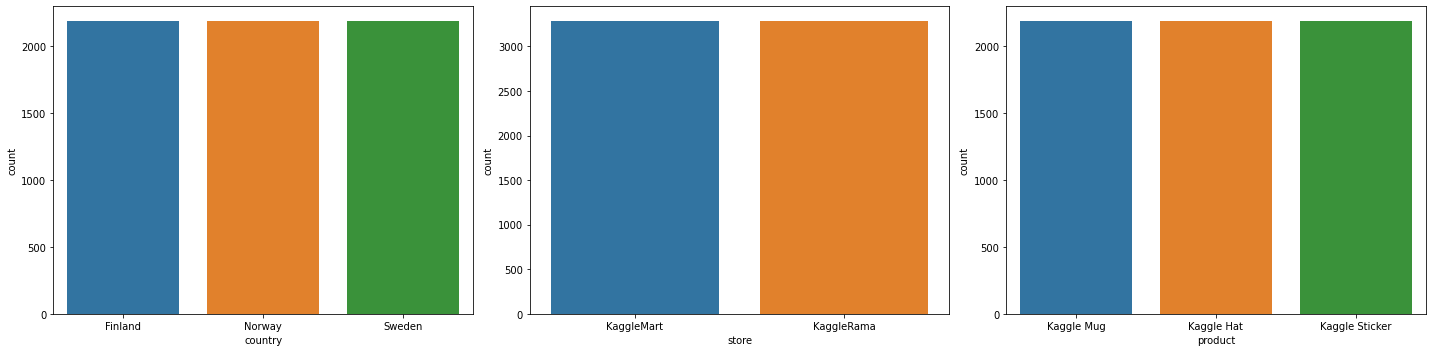

In [57]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax = ax.flatten()
columns = test_df.select_dtypes(include='object').drop('date', axis=1).columns

for i, column in enumerate(columns):
    sns.countplot(x=test_df[column], ax=ax[i])

plt.tight_layout()
fig.show()